#Model comparison and validation for Northern Italy.

###Import Python and Obspy modules

In [1]:
# To keep the figure inside the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import sys

from obspy import Stream, UTCDateTime
from obspy.core import read
from obspy.imaging.beachball import Beachball

###Path specification

In [2]:
# real data and synthetic paths
# ATTENTION: the data headers should be set!
data_path = './data_Emilia_earthquake'
syn_path = './syn_Emilia_earthquake'

###Stations IDs
#####In this example, we choose two stations: one on rock and the other on sedimentary basin. The goal is to compare the behavior of these stations by doing different measurements on the results.

In [3]:
# You can use * for all stations or specify them in a list as follow:
# Default:
# data_ids = ['IV_BDI_Z.sac', 'IV_TEOL_Z.sac']
# syn_spec3_ids = ['BDI.IV.HXZ.semd.sac', 'VLC.MN.HXZ.semd.sac']

data_ids = ['IV_BDI_Z.sac', 'IV_TEOL_Z.sac']
syn_ids = ['BDI.IV.HXZ.semd.sac', 'VLC.MN.HXZ.semd.sac']

###Read event information

#####Event information is in "CMTSOLUTION" format as follow:

<img src="./figs/event_info.png">

In [4]:
ev_info_path = './events/INGV_2012_05_29__Mw_5_6'
ev_info_dict = {}
with open(ev_info_path) as ev_info:
    ev_ls = ev_info.readlines()
    line1 = ev_ls[0].split()
    ev_info_dict['time'] = UTCDateTime("%s-%s-%sT%s:%s:%s" % (line1[1], line1[2], line1[3], 
                                                              line1[4], line1[5], line1[6]))
    ev_info_dict['lat'] = float(ev_ls[4].split(':')[1])
    ev_info_dict['lon'] = float(ev_ls[5].split(':')[1])
    ev_info_dict['depth'] = float(ev_ls[6].split(':')[1])
    ev_info_dict['mrr'] = float(ev_ls[7].split(':')[1])
    ev_info_dict['mtt'] = float(ev_ls[8].split(':')[1])
    ev_info_dict['mpp'] = float(ev_ls[9].split(':')[1])
    ev_info_dict['mrt'] = float(ev_ls[10].split(':')[1])
    ev_info_dict['mrp'] = float(ev_ls[11].split(':')[1])
    ev_info_dict['mtp'] = float(ev_ls[12].split(':')[1])

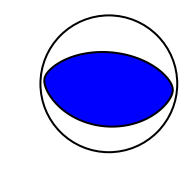

In [5]:
# Graphical representation of the focal mechanism:
focmecs = [ev_info_dict['mrr'], ev_info_dict['mtt'], ev_info_dict['mpp'], 
           ev_info_dict['mrt'], ev_info_dict['mrp'], ev_info_dict['mtp']]
Beachball(focmecs, size=200, linewidth=2, facecolor='b')
plt.show()

###Read station information

In [6]:
sta_info_path = './stations/STATIONS_Bertinoro'
sta_info_dict = {}
with open(sta_info_path) as sta_info:
    sta_ls = sta_info.readlines()
    for sta_line in sta_ls:
        sta_line = sta_line.split()
        sta_id = '%s.%s' % (sta_line[1], sta_line[0])
        # sta_info_dict has the following items: [lat, lon, elevation, depth]
        sta_info_dict[sta_id] = [float(sta_line[2]), float(sta_line[3]), 
                                 float(sta_line[4]), float(sta_line[5])]

###Read real and synthetic waveforms

In [26]:
# Define empty streams and append the traces in the next step.
real_wfs = Stream()
syn_wfs = Stream()
for data_id in data_ids:
    real_wfs.append(read(os.path.join(data_path, data_id))[0])
for syn_id in syn_ids:
    syn_wfs.append(read(os.path.join(syn_path, syn_id))[0])
if len(real_wfs) != len(syn_wfs):
    raise Exception('Number of real (%i) and synthetic (%i) waveforms is not the same!' % (len(real_data), len(syn_data)))
print real_wfs
print syn_wfs

2 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T06:55:39.845000Z - 2012-05-29T08:30:13.145000Z | 20.0 Hz, 113467 samples
IV.TEOL..BHZ | 2012-05-29T06:55:39.195000Z - 2012-05-29T08:30:12.595000Z | 20.0 Hz, 113469 samples
2 Trace(s) in Stream:
IV.BDI..BHZ  | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.944886Z | 200.0 Hz, 100000 samples
IV.TEOL..BHZ | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.944886Z | 200.0 Hz, 100000 samples


###Preparing synthetic waveforms

In [27]:
min_sampling = real_wfs[0].stats.sampling_rate
for real_wf in real_wfs:
    min_sampling = min(min_sampling, real_wf.stats.sampling_rate)
syn_initial_starttime = []
for syn_wf in syn_wfs:
    min_sampling = min(min_sampling, syn_wf.stats.sampling_rate)
    syn_initial_starttime.append(syn_wf.stats.starttime)
real_wfs.resample(min_sampling)
syn_wfs.resample(min_sampling)

2 Trace(s) in Stream:
IV.BDI..BHZ  | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.850000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 1969-12-31T23:59:59.950000Z - 1970-01-01T00:08:19.850000Z | 20.0 Hz, 9999 samples

In [28]:
for i, syn_wf in enumerate(syn_wfs):
    syn_starttime = ev_info_dict['time'] + (UTCDateTime(0) - syn_initial_starttime[i])
    syn_wf.stats.starttime = syn_starttime

slice_starttime = syn_wfs[0].stats.starttime
slice_endtime = syn_wfs[0].stats.endtime
for i in range(len(real_wfs)):
    slice_starttime = max(slice_starttime, real_wfs[i].stats.starttime, syn_wfs[i].stats.starttime)
    slice_endtime = min(slice_endtime, real_wfs[i].stats.endtime, syn_wfs[i].stats.endtime)
    
real_wfs = real_wfs.slice(starttime=slice_starttime, endtime=slice_endtime)
syn_wfs = syn_wfs.slice(starttime=slice_starttime, endtime=slice_endtime) 

In [29]:
real_wfs_cp = real_wfs.copy()
syn_wfs_cp = syn_wfs.copy()

real_wfs_cp.detrend("linear")
real_wfs_cp.taper(max_percentage=0.05, type="hann")
real_wfs_cp.filter("bandpass", freqmin=1.0 / 25.0, freqmax=1.0 / 3.0, zerophase=True)

syn_wfs_cp.detrend("linear")
syn_wfs_cp.taper(max_percentage=0.05, type="hann")
syn_wfs_cp.filter("bandpass", freqmin=1.0 / 25.0, freqmax=1.0 / 3.0, zerophase=True)

2 Trace(s) in Stream:
IV.BDI..BHZ  | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples
IV.TEOL..BHZ | 2012-05-29T07:00:02.930000Z - 2012-05-29T07:08:22.830000Z | 20.0 Hz, 9999 samples

###Plot the waveforms

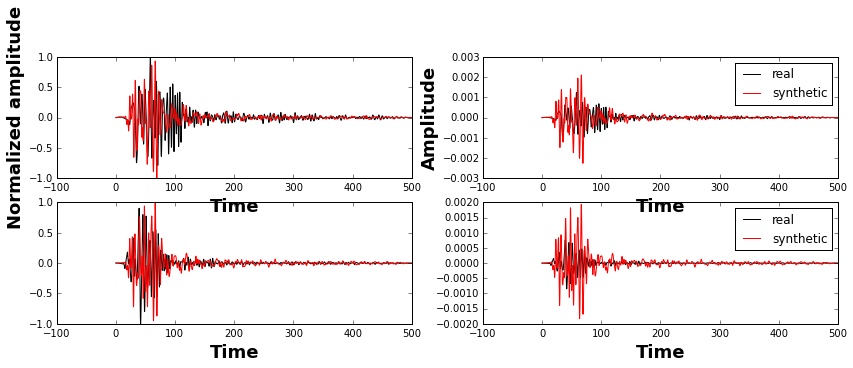

In [42]:
plt.figure(figsize=(len(real_wfs_cp)*7, 10))
for i, real_wf in enumerate(real_wfs_cp):
    plt.subplot(len(real_wfs_cp)*2, 2, 2*i+1)
    tax_real = np.linspace(0, (real_wf.stats.npts - 1)/real_wf.stats.sampling_rate, real_wf.stats.npts)
    plt.plot(tax_real, real_wf.data/max(abs(real_wf.data)), c='k', label='real')
    plt.xlabel('Time', size=18, weight='bold')
    if i == 0:
        plt.ylabel('Normalized amplitude', size=18, weight='bold')
    
    time_difference = syn_wfs_cp[i].stats.starttime - real_wf.stats.starttime
    tax_syn = time_difference + np.linspace(0, (syn_wfs_cp[i].stats.npts - 1)/syn_wfs_cp[i].stats.sampling_rate, syn_wfs_cp[i].stats.npts)
    plt.plot(tax_syn, syn_wfs_cp[i].data/max(abs(syn_wfs_cp[i].data)), c='r', label='synthetic')
    plt.xlabel('Time', size=18, weight='bold')
    
    plt.subplot(len(real_wfs_cp)*2, 2, 2*i+2)
    tax_real = np.linspace(0, (real_wf.stats.npts - 1)/real_wf.stats.sampling_rate, real_wf.stats.npts)
    plt.plot(tax_real, real_wf.data/1.e9, c='k', label='real')
    plt.xlabel('Time', size=18, weight='bold')
    
    time_difference = syn_wfs_cp[i].stats.starttime - real_wf.stats.starttime
    tax_syn = time_difference + np.linspace(0, (syn_wfs_cp[i].stats.npts - 1)/syn_wfs_cp[i].stats.sampling_rate, syn_wfs_cp[i].stats.npts)
    plt.plot(tax_syn, syn_wfs_cp[i].data, c='r', label='synthetic')
    plt.xlabel('Time', size=18, weight='bold')
    if i == 0:
        plt.ylabel('Amplitude', size=18, weight='bold')
    plt.legend()

In [13]:
#################### TRASH #########################


import pyflex

config = pyflex.Config(
    min_period=50.0, max_period=150.0,
    stalta_waterlevel=0.08, tshift_acceptance_level=15.0,
    dlna_acceptance_level=1.0, cc_acceptance_level=0.80,
    c_0=0.7, c_1=4.0, c_2=0.0, c_3a=1.0, c_3b=2.0, c_4a=3.0, c_4b=10.0)

print wf_spec3.stats.npts
print wf_data.stats.npts



windows = pyflex.select_windows(wf_data, wf_spec3, config, plot=True)



sta_lats = []
sta_lons = []
sta_names = []
for sta_info in sta_info_dict:
    sta_lats.append(sta_info_dict[sta_info][0])
    sta_lons.append(sta_info_dict[sta_info][1])
    sta_names.append(sta_info)

plt.figure(figsize=(20, 10))
m = Basemap(projection='merc', resolution="l",
            llcrnrlon=6, llcrnrlat=38, 
            urcrnrlon=18, urcrnrlat=48)
m.drawcountries(color="black", linewidth=1)
m.drawcoastlines()
m.bluemarble()
x, y = m(sta_lons, sta_lats)
m.scatter(x, y, 200, color="r", marker="v", edgecolor="k", zorder=3)
for i in range(len(sta_names)):
    plt.text(x[i], y[i], sta_names[i], va="top", family="monospace", weight="bold")

ax = plt.gca()
x_ev, y_ev = m(ev_info_dict['lon'], ev_info_dict['lat'])
print ev_info_dict['lon']
print ev_info_dict['lat']
b = Beachball(focmecs, xy=(x_ev, y_ev), width=100, linewidth=1)
ax.add_collection(b)

plt.show()

[]